In [75]:
%matplotlib widget
import numpy as np
import seaborn as sns
import pandas as pd
from functools import reduce
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import sys
import os


In [76]:
def load_csv(path):
    return pd.read_csv(path)

0/7: FV10__20181106_121902_rstats_w
/home/dkermany/ripley_results/FV10__20181106_121902_rstats_w.csv


AttributeError: 'numpy.ndarray' object has no attribute 'xlabel'

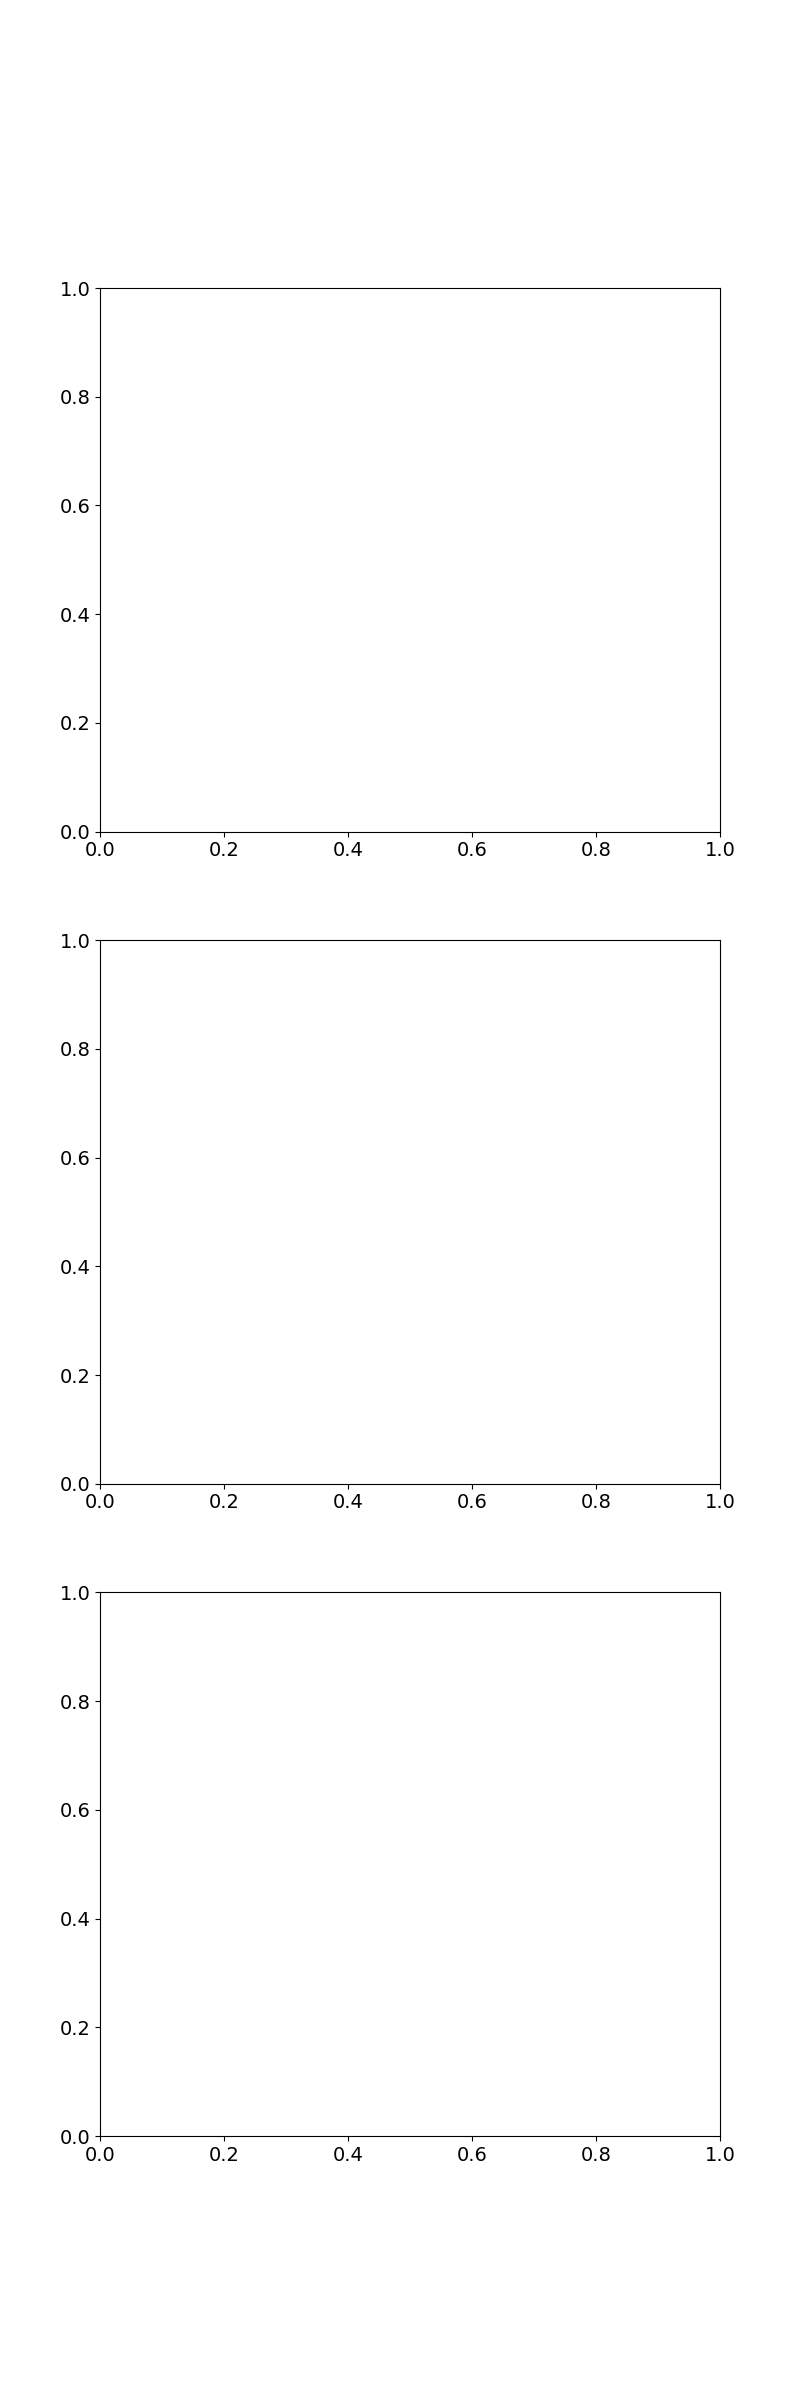

In [77]:
filenames = [
    "FV10__20181106_121902_rstats_w",
    "FV10__20181009_103052_rstats_w",
    "FV10__20181004_122358_rstats_w",
    "FV10__20181008_104428_rstats_w",
    "FV10__20190620_111343_rstats_w",
    "FV10__20181005_104242_rstats_w",
    "FV10__20181106_172421_rstats_w",
]

for i, f in enumerate(filenames):
    rstats_path = f"/home/dkermany/ripley_results/{f}.csv"
    rand_rstats_path = f"/home/dkermany/ripley_results/FV10__{'_'.join(f.split('_')[2:4])}_random_rstats_w.csv"
    print(f"{i}/{len(filenames)}: {f}")

    rstats = load_csv(rstats_path)
    rand_rstats = load_csv(rand_rstats_path)
    
    ## Uncomment to restrict maximum radius in the plots
    rstats = rstats[rstats["Radius (r)"] <= 102]
    rand_rstats = rand_rstats[rand_rstats["Radius (r)"] <= 102]

    print(rstats_path)

    f, axes = plt.subplots(3, figsize=(8,24))
    plt.ticklabel_format(style="plain")
    plt.rcParams.update({"font.size": 14})
    axes.xlabel("Radius (μm)")

    # K
    sns.lineplot(data=rstats, x="Radius (r)", y="K(r)", ax=axes[0])
    sns.lineplot(data=rand_rstats, x="Radius (r)", y="K(r)", ax=axes[0], alpha=0, errorbar=("pi", 95))
    axes[0].set(xlabel="Radius (μm)")
    # L
    sns.lineplot(data=rstats, x="Radius (r)", y="L(r)", ax=axes[1])
    sns.lineplot(data=rand_rstats, x="Radius (r)", y="L(r)", ax=axes[1], alpha=0, errorbar=("pi", 95))
    axes[1].plot([0, 100], [0, 100], linewidth=1, linestyle="dotted", color="#aaa") # Expected line
    axes[1].set(xlabel="Radius (μm)")
    
    # H
    sns.lineplot(data=rstats, x="Radius (r)", y="H(r)", ax=axes[2])
    sns.lineplot(data=rand_rstats, x="Radius (r)", y="H(r)", ax=axes[2], alpha=0, errorbar=("pi", 95))
    axes[2].plot([0, 100], [0, 0], linewidth=1, linestyle="dotted", color="#aaa") # Expected line
    axes[2].set(xlabel="Radius (μm)")


    plt.savefig(f"/home/dkermany/ripley_plots/{f}.png", dpi=600)
    plt.show()